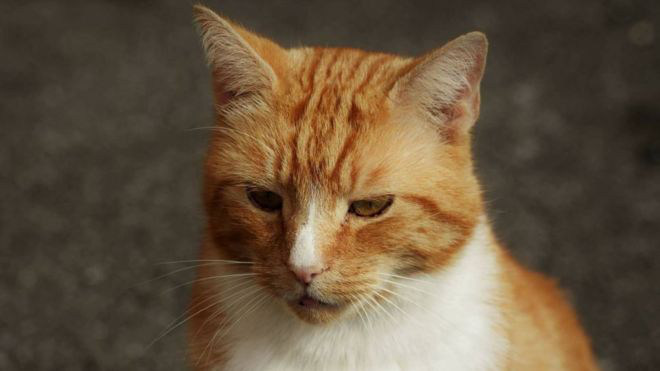

In [1]:
from PIL import Image


path_to_image = 'data/cat_0.bmp'

img = Image.open(path_to_image)
img

In [2]:
def LSB_decode(img, rate, data_len):
    data = ''
    width, height = img.size
    pixels = img.load()
    i = 0
    now_decoding = 0
    for x in range(width):
        for y in range(height):
            for v in range(len(pixels[x,y])):
                color = list(pixels[x,y])
                if i > 1 and now_decoding < data_len:
                    if (color[v] & 0b1) == 0:
                        data += '0'
                    else:
                        data += '1'
                    now_decoding += 1
                    i -= 1
                else:
                    i += rate
    return data

True


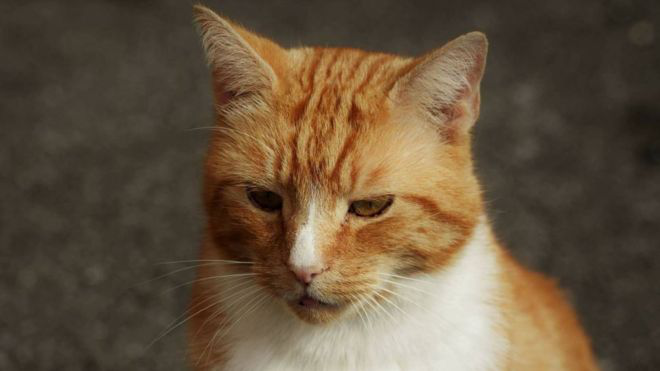

In [3]:
def LSB_encode(img, data, rate):
    res = img.copy()
    width, height = res.size
    pixels = res.load()
    i = 0
    now_coding = 0
    for x in range(width):
        for y in range(height):
            for v in range(len(pixels[x,y])):
                if i > 1 and now_coding < len(data):
                    color = list(pixels[x,y])
                    if data[now_coding] == '0':
                        color[v] = color[v] & 0b11111110
                    else:
                        color[v] = color[v] | 0b1
                    i -= 1
                    now_coding += 1
                    pixels[x,y] = tuple(color)
                else:
                    i += rate
    return res


code = '001001001110101111111'
rate = 0.21
encoded_img = LSB_encode(img, code, rate)
print(code == LSB_decode(encoded_img, rate, len(code)))
encoded_img

True


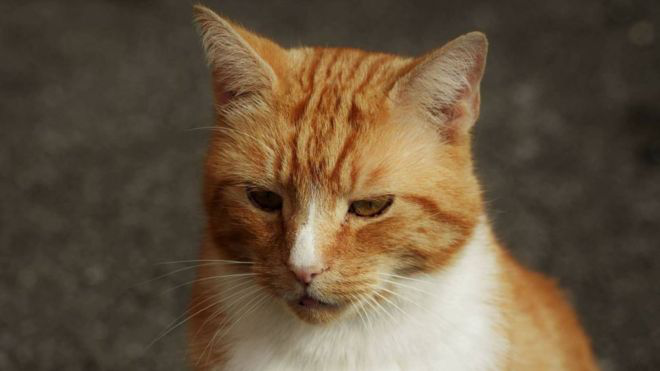

In [4]:
import random


def LSBM_encode(img, data, rate):
    res = img.copy()
    width, height = res.size
    pixels = res.load()
    i = 0
    now_coding = 0
    for x in range(width):
        for y in range(height):
            for v in range(len(pixels[x,y])):
                if i > 1 and now_coding < len(data):
                    color = list(pixels[x,y])
                    if data[now_coding] == '0' and color[v] % 2 != 0:
                        if color[v] == 255:
                            color[v] = 254
                        else:
                            color[v] = color[v] + random.choice([-1, 1]) 
                    elif data[now_coding] == '1' and color[v] % 2 != 1:
                        if color[v] == 0:
                            color[v] = 1
                        else:
                            color[v] = color[v] + random.choice([-1, 1])
                    i -= 1
                    now_coding += 1
                    pixels[x,y] = tuple(color)
                else:
                    i += rate
    return res


code = '001001001110101111111'
rate = 0.21
encoded_img = LSBM_encode(img, code, rate)
print(code == LSB_decode(encoded_img, rate, len(code)))
encoded_img

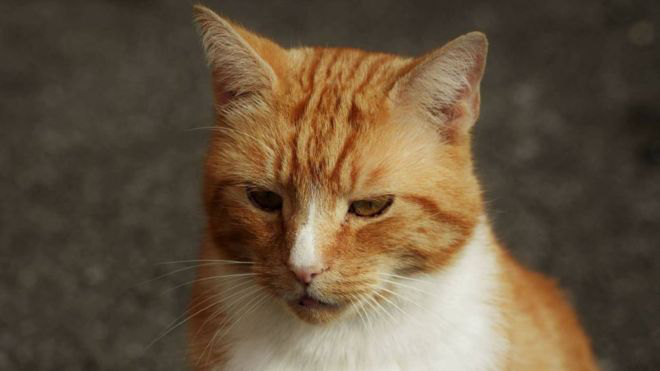

In [5]:
import numpy


def get_inverse_idx(c, m):
    H = numpy.array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
                     [0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1],
                     [0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
                     [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
                    ])
    c = numpy.array(c)
    m = numpy.array(m)
    s = (((H @ numpy.transpose(c)) % 2) + numpy.transpose(m)) % 2
    s = numpy.transpose(s)
    return s[0] + 2 * s[1] + 4 * s[2] + 8 * s[3]


def hamming_encode(img, data, *args, **kwargs):
    img_bytes = list(img.tobytes())
    while len(data) % 4 != 0:
        data += '0'
    bytes_c = 0
    data_c = 0
    while data_c < len(data):
        c = [x & 0b1 for x in img_bytes[bytes_c:bytes_c+15]]
        m = [int(x) for x in data[data_c:data_c+4]]
        i = get_inverse_idx(c, m)
        if i != 0:
            i -= 1
            if img_bytes[bytes_c + i] & 0b1 == 0:
                img_bytes[bytes_c + i] = img_bytes[bytes_c + i] | 0b1
            else:
                img_bytes[bytes_c + i] = img_bytes[bytes_c + i] & 0b11111110
        bytes_c += 15
        data_c += 4
    new_img = Image.frombytes('RGB', img.size, bytes(img_bytes))
    return new_img


code = '001001001110101111111'
encoded_img = hamming_encode(img, code)
encoded_img

In [6]:
import pandas, os, zipfile


def get_test_data(rate, pixels):
    max_amount_bytes = int((pixels * rate) // 8)
    with open('./data/text.txt', 'r') as f:
        text = list(bytes(f.read(), encoding='utf-8'))
    return ''.join(format(x, '08b') for x in text[:max_amount_bytes])


def get_file_size(file):
    with open(file, 'rb') as f:
        c = f.read()
    return len(c)


def get_stat_with_rate(rate, path_to_image, meth):
    stat = {'image': path_to_image,
            'method': meth.__name__,
            'rate': rate,
            'png': 0,
            'jpg': 0,
            'zip': 0
           }
    original_size = get_file_size(path_to_image)
    img = Image.open(path_to_image)
    data = get_test_data(rate, img.size[0] * img.size[1])
    img = meth(img, data, rate)
    img.save('test.jpeg', 'JPEG')
    stat['jpg'] = original_size / get_file_size('test.jpeg')
    os.remove('test.jpeg')
    img.save('test.png', 'PNG')
    stat['png'] = original_size / get_file_size('test.png')
    os.remove('test.png')
    img.save('test.bmp', 'BMP')
    zipfile.ZipFile('test.zip', mode='w').write("test.bmp")
    stat['zip'] = original_size / get_file_size('test.zip')
    os.remove('test.bmp')
    os.remove('test.zip')
    return stat


def get_total_stat():
    res = { 'image': [],
            'method': [],
            'rate': [],
            'png': [],
            'jpg': [],
            'zip': []
          }
    stat = get_stat_with_rate(0.8, './data/cat_1.bmp', hamming_encode)
    for key in stat:
        res[key].append(stat[key])
    rates = [0.25, 0.8, 1.5, 2, 3]
    methods = [LSB_encode, LSBM_encode]
    for rate in rates:
        for method in methods:
            print(rate, method)
            stat = get_stat_with_rate(rate, './data/cat_1.bmp', method)
            for key in stat:
                res[key].append(stat[key])
    
    stat = get_stat_with_rate(0, './data/cat_1.bmp', LSB_encode)
    for key in stat:
        res[key].append(stat[key])
    return pandas.DataFrame.from_dict(res)

In [7]:
lsb_stat = get_total_stat()

0.25 <function LSB_encode at 0x7f25742b2400>
0.25 <function LSBM_encode at 0x7f25742b20d0>
0.8 <function LSB_encode at 0x7f25742b2400>
0.8 <function LSBM_encode at 0x7f25742b20d0>
1.5 <function LSB_encode at 0x7f25742b2400>
1.5 <function LSBM_encode at 0x7f25742b20d0>
2 <function LSB_encode at 0x7f25742b2400>
2 <function LSBM_encode at 0x7f25742b20d0>
3 <function LSB_encode at 0x7f25742b2400>
3 <function LSBM_encode at 0x7f25742b20d0>


In [8]:
lsb_stat

,image,method,rate,png,jpg,zip
0,./data/cat_1.bmp,hamming_encode,0.80,3.608561,49.547579,0.999959
1,./data/cat_1.bmp,LSB_encode,0.25,4.425551,49.584010,0.999959
2,./data/cat_1.bmp,LSBM_encode,0.25,4.345034,49.584900,0.999959
3,./data/cat_1.bmp,LSB_encode,0.80,3.745095,49.515635,0.999959
4,./data/cat_1.bmp,LSBM_encode,0.80,3.592063,49.460716,0.999959
5,./data/cat_1.bmp,LSB_encode,1.50,3.305763,49.428883,0.999959
6,./data/cat_1.bmp,LSBM_encode,1.50,3.141573,49.407684,0.999959
7,./data/cat_1.bmp,LSB_encode,2.00,3.119740,49.393562,0.999959
8,./data/cat_1.bmp,LSBM_encode,2.00,2.926428,49.464255,0.999959
9,./data/cat_1.bmp,LSB_encode,3.00,2.868159,49.306358,0.999959
